# The basics of time series analysis

- What's a time series?
  - It's a table of values, such as temperature or stock price, that are observed at regular times, such as every hour or every day.
  - Here is a simple time series: Humidity in grams of water per cubic meter of air in The Neighborhood over 10 days.

| Day          | Humidity    |
| ------------ | ----------- |
| 11 June 2022 | 23          |
| 12 June 2022 | 21          |
| 13 June 2022 | 24          |
| 14 June 2022 | 19          |
| 15 June 2022 | 18          |
| 16 June 2022 | 20          |
| 17 June 2022 | 21          |
| 18 June 2022 | 22          |
| 19 June 2022 | 20          |
| 20 June 2022 | 21          |

- One would want to know: what's the humidity after 20 June 2022? Predicting the data values (Humidity) in the future is called forecasting.

## Common features in time series data


![Trends and seasons](trend_seasonal.png)

- These are three common features in every time series data:
    - __Seasons__: The regular ups and downs in your data, like in the figure above.
    - __Trends__: When you find that data is general going upward or downword. In the figure above, there is an upward trend.
    - __Cycles__: Where there are ups and downs in the data that do not seem to repeat regularly.
- We can observe the above three features by plotting the data, and checking it visually.

## Stationarity

- A stationary time series: it's the time series in which the average and variance do not change; so these statistical properties are *independent of time*. 
- Therefore, a time series with trends is not stationary. An example of such data is in the figure above as __Residuals__.
- Non-stationary data are not easy to predict, but stationary data are much easier to predict.
- Therefore, we need to make our time series data stationary before we feed them into statistical models.
- You will learn how to turn non-stationary data into stationary data by using differencing.

## The dataset

We obtain the dataset from the Github page of John Hopkins Center for System Science and Engineering:

[https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)


# Load & Prepare Data

In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.pylab import rcParams
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')


#### Get the confirmed cases from the dataset

In [2]:
cnfd_df = pd.read_csv("./time_series_covid19_confirmed_global.csv")
cnfd_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/12/22,10/13/22,10/14/22,10/15/22,10/16/22,10/17/22,10/18/22,10/19/22,10/20/22,10/21/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,200729,200846,201014,201096,201212,201276,201503,201557,201750,201949
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,332555,332579,332598,332619,332638,332645,332673,332701,332719,332739
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,270722,270722,270734,270734,270740,270757,270766,270768,270769,270771
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,46366,46366,46366,46366,46366,46366,46366,46449,46449,46449
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,103131,103131


In [3]:
cnfd_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/12/22', '10/13/22', '10/14/22', '10/15/22', '10/16/22', '10/17/22',
       '10/18/22', '10/19/22', '10/20/22', '10/21/22'],
      dtype='object', length=1008)

So the columns are arranged as follows: <br>
<ul>
    <li>
        feature columns such as Province, Country etc. </li>
    <li>date columns, starting from the first reporting date, 1/22/2020, until two days ago (with respect to the time of running this project on October 22nd, 2022)</li>
   </ul>
 
The date columns start from 1/22/20, so let's take the data in these columns separately.
    
    

In [4]:
df = cnfd_df.loc[:, '1/22/20':]

Since all the dates are in columns we need to transpose it to make it as indexes

In [5]:
df = df.transpose()

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


Then summing the values row wise to get aggregated values over all the countries

In [7]:
df = df.sum(axis = 1)

In [8]:
df.head()

1/22/20     557
1/23/20     657
1/24/20     944
1/25/20    1437
1/26/20    2120
dtype: int64

### Now preparing the dataset as a dataframe having just two columns 
- First Date
- Second Confirmed Cases

In [9]:
dataset = df.reset_index()

In [10]:
dataset.columns = ['ds', 'y']

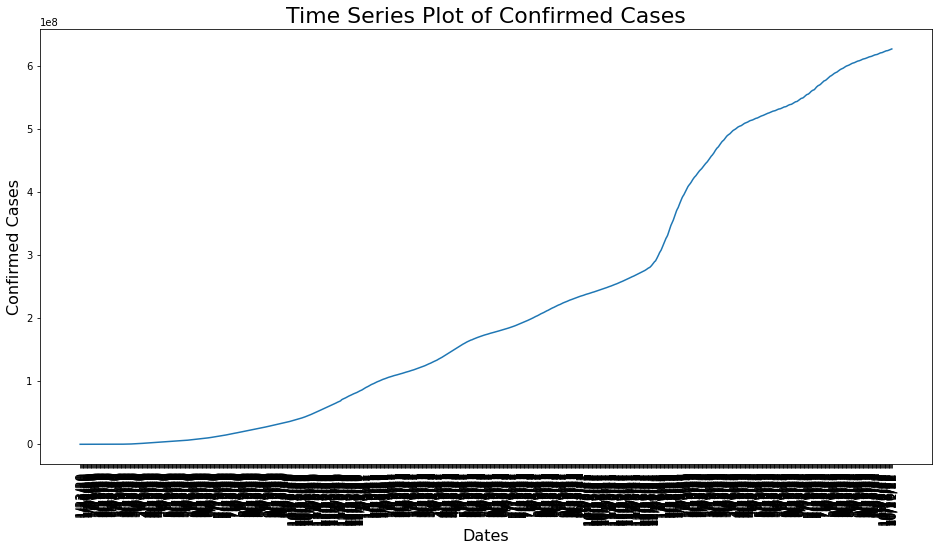

In [11]:
rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = 'ds', y = 'y', data = dataset, palette = "inferno")
plt.title("Time Series Plot of Confirmed Cases", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("Confirmed Cases", fontsize = 16)
plt.show()

The dataset is very huge having 1003 dates. Hence it is not evident in x-axis.

Let's see a smaller dataset of last 30 days(latest)

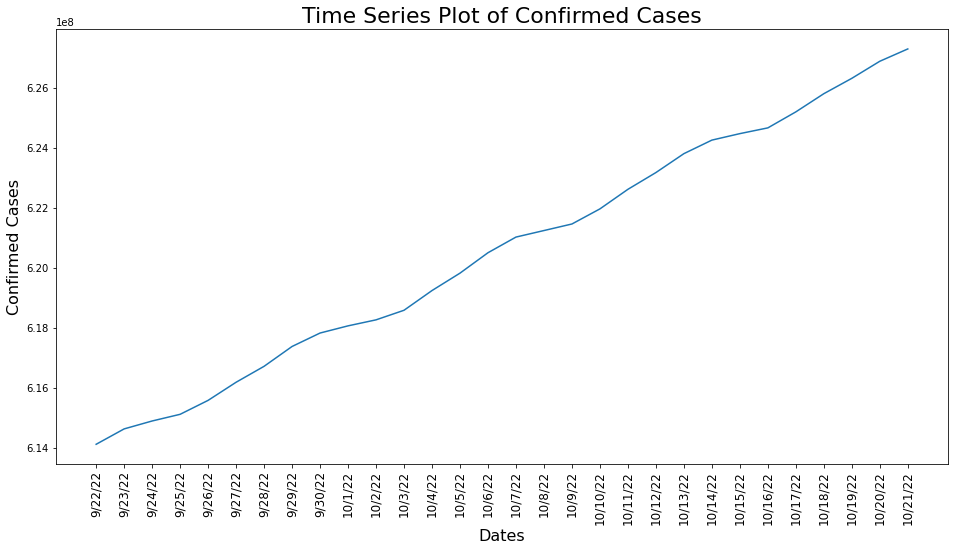

In [12]:
rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = 'ds', y = 'y', data = dataset.iloc[-30:], palette = "inferno")
plt.title("Time Series Plot of Confirmed Cases", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("Confirmed Cases", fontsize = 16)
plt.show()

The trend is evidently upwards and seasonality is not evident as this is just a data of 30 days.

This time series is obvious non-stationary, and we cannot observe any seasonal behavior here. Let's perform seasonal decomposition of the data by using the `seasonal_decompose()` function from `statsmodel`:

For this we need to convert our column 'ds' into a datetime object

In [13]:
dataset['ds'] = pd.to_datetime(dataset['ds'])

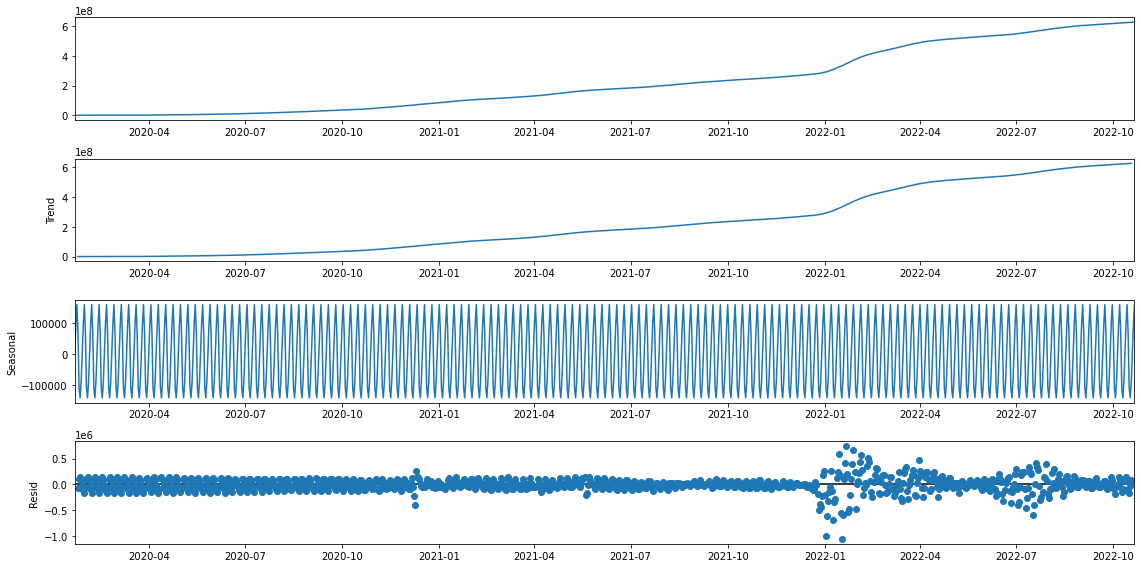

In [14]:
rcParams['figure.figsize'] = (16, 8)
result = sm.tsa.seasonal_decompose(dataset.set_index('ds').resample('D').sum(), model='add')
result.plot()
plt.show()

The data is both seasonal and trending upwords. We need the data to be stationary so that we can apply our models to it.

Let's make our dataset stationary by taking the difference between consecutive elements, which in our case will be the daily change in the number of deaths. To do this, we will use the `diff()` method from the `dataset` DataFrame object.

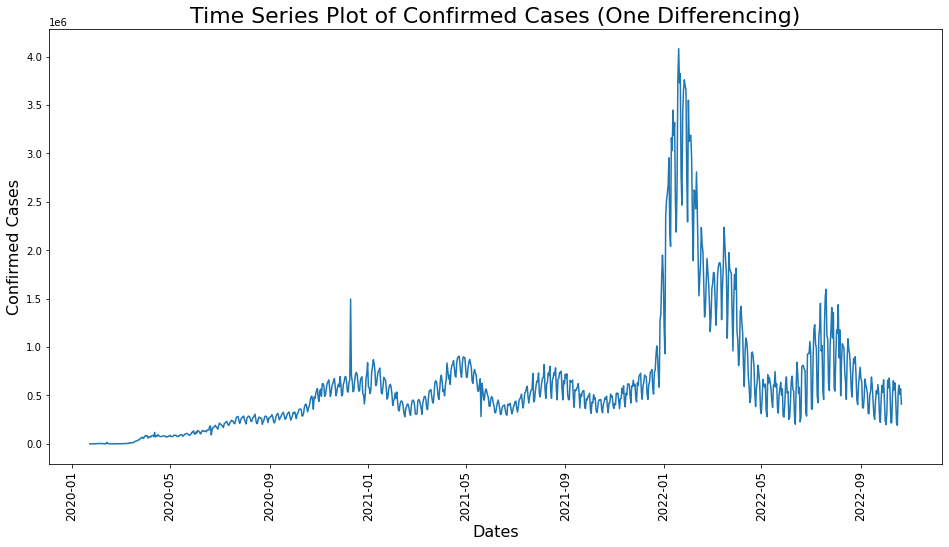

In [15]:
rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = dataset.set_index('ds').index, y = 'y', data = dataset.set_index('ds').diff(), palette = "inferno")
plt.title("Time Series Plot of Confirmed Cases (One Differencing)", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("Confirmed Cases", fontsize = 16)
plt.show()

Still a seasonality or trend can be observed, So let us difference it once more

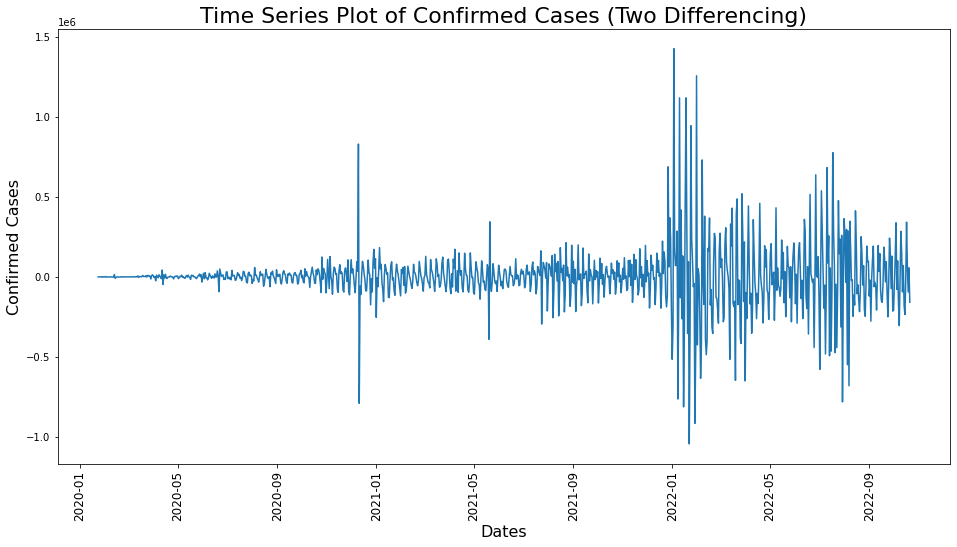

In [16]:
rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = dataset.set_index('ds').index, y = 'y', data = dataset.set_index('ds').diff().diff(), palette = "inferno")
plt.title("Time Series Plot of Confirmed Cases (Two Differencing)", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("Confirmed Cases", fontsize = 16)
plt.show()

### ADF Tests can also be done to check stationarity of the data, but however we shall not do it here.
For more info on this check out - https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

### Non - Stationary Dataset

In [17]:
dataset_diff = dataset.set_index('ds').diff().diff()

We need to remove the first two data point here, which will be two `None` values after applying `diff()` twice:

In [18]:
dataset_diff = dataset_diff.loc['2020-01-24':]

### Train/Test Split

Now we haev to split our dataset into a training and a test set. 
- When we train ML models, we typically use 20% of the dataset as a test set.
- In time series analysis, the the size of the test set should be close to the extent of the future data.
- In this project, we are only going to predict 1 month into the future. Therefore, we will use all the data before 21st September 2022 as training set.



2022-09-21


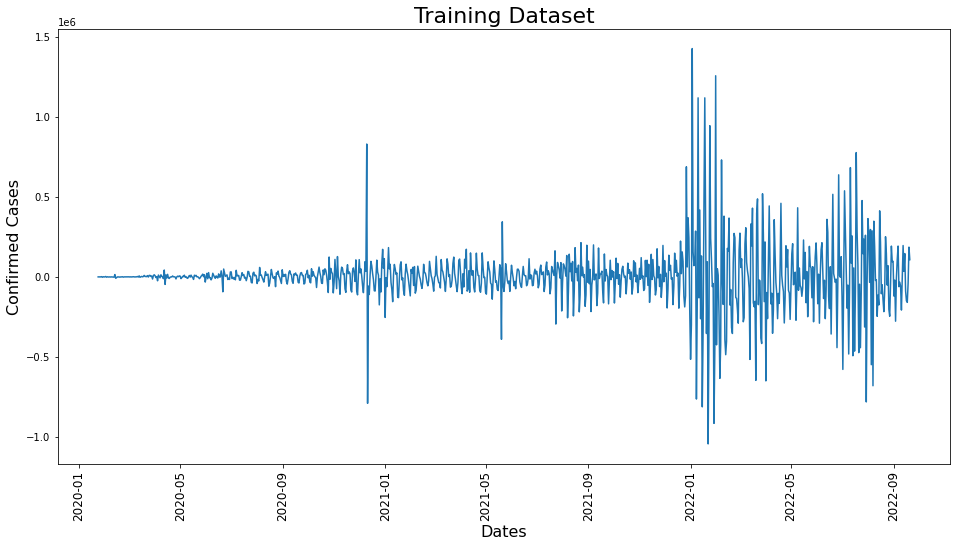

In [19]:
cutoff_date = '2022-09-21'

print(cutoff_date)

train = dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]
test = dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)]

rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = train.index, y = 'y', data = train, palette = "inferno")
plt.title("Training Dataset", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("Confirmed Cases", fontsize = 16)
plt.show()

# Model Exploration
- We have train/test split
- We would be using the __Mean Absolute Error__ as our evaluation metric to choose the best model

## Exponential Smoothing Models
- Grid Search for best hyperparameters in Exponential Smoothing Class

##### Method for Holt Winter’s Exponential Smoothing forecast

In [20]:
def exp_smoothing_forecast(history, config):
#     print("Inside exp smoothing")
    t, s, p = config
    if (t == None):
        an_array = np.empty(notbs)
        an_array[:] = np.nan
        return an_array
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, seasonal = s, seasonal_periods = p)
    # fit model
    model_fit = model.fit(optimized = True)
    # make forecast
    predictions = model_fit.forecast(notbs)
    return predictions

#####  mean absolute percentage error or mape

In [21]:
def measure_mae(actual, predicted):
    if True in np.isnan(predicted):
        return None
    return mean_absolute_error(actual, predicted[np.logical_not(np.isnan(predicted))])

##### Model Training

In [22]:
def model_training(n_test, cfg):
#     print("Inside model training")
    # train-test dataset
    tr, te = train['y'], test['y']
    # seed history with training dataset
    history = [x for x in tr]
    # model forecast
    predictions = exp_smoothing_forecast(history, cfg)
    # estimate prediction error
    error = measure_mae(te, predictions)
    return error

##### Model Evaluation

In [23]:
def model_eval(n_test, i, cfg, debug = False):
    # print("Inside model_eval")
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    warnings.filterwarnings("ignore")
    result = model_training(n_test, cfg)
    # check for an interesting result
#     if result is not None:
#         print(i)
#         print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

##### Grid Search for Exponential Smoothing

In [24]:
def grid_search(cfg_list, n_test, parallel = False):
    scores = None
    if parallel:
        # execute configs in parallel
        print("Parallel Execution")
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing')
        tasks = (delayed(model_eval)(n_test, index, cfg) for index, cfg in enumerate(cfg_list))
        scores = executor(tasks)
    else:
        scores = [model_eval(n_test, index, cfg) for index, cfg in enumerate(cfg_list)]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup:tup[1])
    return scores

##### Configuration Setting - Hyperparameters

In [25]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    s_params = ['add', None]
    p_params = seasonal
    # create config instances
    for t in t_params:
        for s in s_params:
            for p in p_params:
                cfg = [t, s, p]
                models.append(cfg)
    return models

In [26]:
%%time
# model configs
cfg_list = exp_smoothing_configs(seasonal = [3, 6, 12])

notbs = test.shape[0]
# grid search
scores = grid_search(cfg_list, notbs)



CPU times: total: 516 ms
Wall time: 498 ms


In [27]:
scores[:3]

[("['add', 'add', 6]", 142380.6178541345),
 ("['mul', 'add', 6]", 142380.6178541345),
 ("['add', None, 3]", 142445.6566106905)]

##### The best model from Holt Winters has __142,380.61__  Mean Absolute Error

## Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

SARIMAX is one of the time series models in the python statistics library `statsmodels`.

SARIMAX uses two sets of parameters:
- The `order`: a tuple of values `p`, `q` and `d`. They control the number of parameters in the model. Here, let's use p=2, q=1 and d=3.
- The `seasonal_order`: a tuple of values `P`, `D`, `Q` and `s`. They control the seasonal component of the model, and `s` is the periodicity of the dates. So for example, weekly periodicity can be set with `s=7`.

##### In a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model.


In [28]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      m=7,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=25881.403, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26311.172, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=25762.446, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=25949.298, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26309.181, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=26313.147, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=25747.353, Time=1.25 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=25735.524, Time=2.39 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=25738.718, Time=0.48 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=25736.033, Time=3.51 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=25736.380, Time=1.51 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=25805.362, Time=1.30 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=25694.232, Time=3.49 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=25697.672, Time=0.71 sec
 ARIMA(2,0,0)(2,0,0

Note that this gives us the best mode here: "Best model:  SARIMAX(5,0,3)(2,0,1)[7]". Now let's fit it.

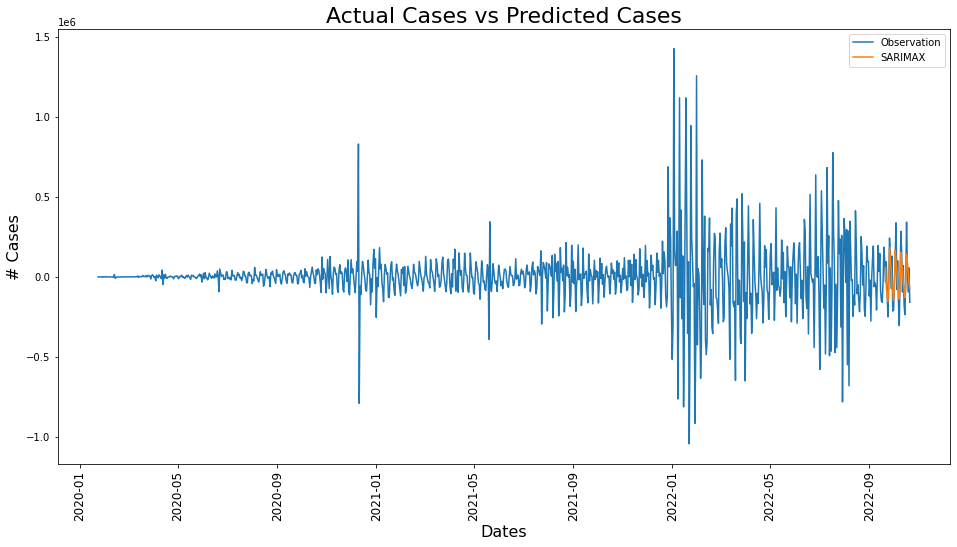

SARIMAX auto MAPE =  96001.6704211923


In [29]:
sarimax_prediction = model.predict(n_periods = test.shape[0])
sarimax_prediction = pd.DataFrame({'ds':test.index,'y':sarimax_prediction})
sarimax_prediction.set_index('ds', inplace = True)


rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = dataset_diff.index, y = 'y', data = dataset_diff, label = "Observation", palette = "inferno")
sns.lineplot(x = sarimax_prediction.index, y = 'y', data = sarimax_prediction, label = "SARIMAX", palette = "inferno")
plt.title("Actual Cases vs Predicted Cases", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("# Cases", fontsize = 16)
plt.legend()
plt.show()

print('SARIMAX auto MAPE = ', measure_mae(sarimax_prediction, test))

##### The best model from SARIMAX have __96,001.67__ Mean Absolute Percentage Error

## Forcasting using Facebook's Prophet model

This is the open source time series library released by Facebook. It is also widely used by Facebook in their own time series analysis tasks. Facebook prophet does not require that you specify or search for hyperparameters. The model can act as a black box that does all the required computations on its own. And it works with the same object-fit-predict API.

Prophet expects the data frame to have 2 columns with names `ds` and `y`, unlike SARIMAX.

In [30]:
train['ds'] = train.index.values

In [31]:
train.head()

,y,ds
ds,,
2020-01-24,187.0,2020-01-24
2020-01-25,206.0,2020-01-25
2020-01-26,190.0,2020-01-26
2020-01-27,126.0,2020-01-27
2020-01-28,1842.0,2020-01-28


In [32]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- Now let's use the model to generate the predictions for the test set.
- First we create the `future` data frame using `make_future_dataframe()`, then we call the `predict()` function.
- In `make_future_dataframe()`, we pass the `periods` parameter, which is the number of days we want for prediction.

In [33]:
future = m.make_future_dataframe(periods = test.shape[0])
prophet_prediction = m.predict(future)

In [34]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= cutoff_date]
print('Prophet MAE = ', measure_mae(prophet_future, test))

Prophet MAE =  107325.82181749436


##### The baseline model from Prophet have      __107,325.82__        Mean Absolute Error

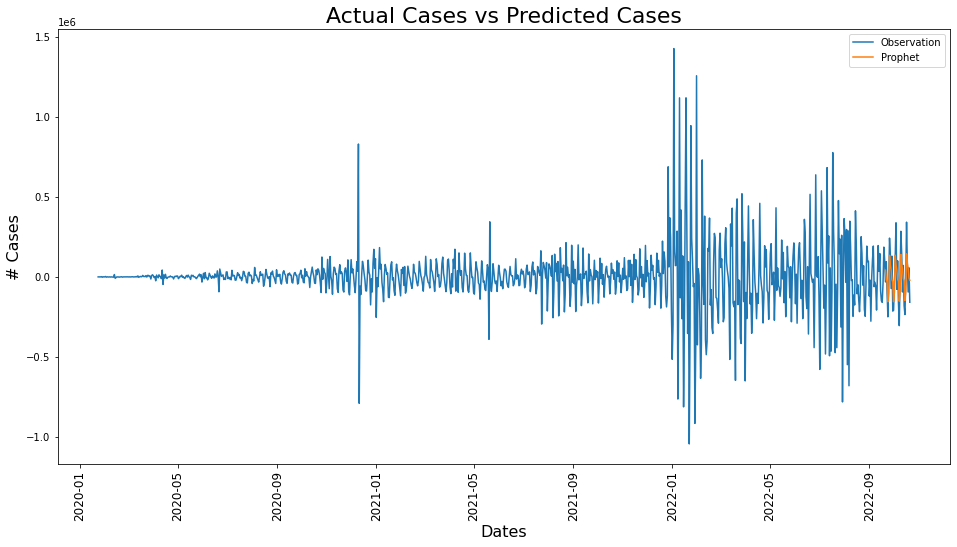

In [35]:
rcParams['figure.figsize'] = (16, 8)
sns.lineplot(x = dataset_diff.index, y = 'y', data = dataset_diff, label = "Observation", palette = "inferno")
sns.lineplot(x = prophet_future.index, y = prophet_future.values, data = prophet_future, label = "Prophet", palette = "inferno")
plt.title("Actual Cases vs Predicted Cases", fontsize = 22)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Dates", fontsize = 16)
plt.ylabel("# Cases", fontsize = 16)
plt.legend()
plt.show()

## Preparing the dataset for XGBOOST and NN
- Even a time-series data can be converted to a regression problem 
- It can be done by building features from time series date objects

Unlike the prophet and SAIMAX models, the two models we will train now, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [36]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    X['year'] = t.index.year
    y = t.y
    return X, y


featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear,year
0,24,1,1,4,24,4,2020
1,25,1,1,5,25,4,2020
2,26,1,1,6,26,4,2020
3,27,1,1,0,27,5,2020
4,28,1,1,1,28,5,2020


### Train/Test Split

In this section we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [37]:
X_train, y_train = featurize(dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]) 
X_test, y_test = featurize(dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)])

Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:


In [38]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [39]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

Note: Same scaler object is used for tranforming test data as well.

## Train the XGBOOST models

In [40]:
xgb_model = XGBRegressor(n_estimators = 100, max_depth = 7)

In [41]:
xgb_model.fit(scaled_train, y_train, eval_set = [(scaled_train, y_train), (scaled_test, y_test)], verbose = False)
xgb_pred = xgb_model.predict(scaled_test)

In [42]:
print('XGBOOST MAE = ', measure_mae(xgb_pred, y_test))

XGBOOST MAE =  93801.37079448084


##### The baseline model from XGBOOST have      __93801.37__        Mean Absolute Error

## Train the Neural Network Model

In [43]:
NN_model = Sequential()
NN_model.add(Dense(128, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(64))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=210, verbose=False)
NN_prediction = NN_model.predict(scaled_test)

In [44]:
print('NN MAE = ', measure_mae(NN_prediction, test))

NN MAE =  124804.636496267


##### The baseline model from Neural Network have 124,737.79 Mean Absolute Error

In [45]:
print('XGBOOST MAE = ', measure_mae(xgb_pred, y_test))
print('Prophet MAE = ', measure_mae(prophet_future, test))
print('SARIMAX MAE = ', measure_mae(sarimax_prediction, test))
print('NN MAE = ', measure_mae(NN_prediction, test))

XGBOOST MAE =  93801.37079448084
Prophet MAE =  107325.82181749436
SARIMAX MAE =  96001.6704211923
NN MAE =  124804.636496267


The peformance of NN is the lowest, while that of XGBOOST is the highest. <br>
Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

<Figure size 1440x1440 with 0 Axes>

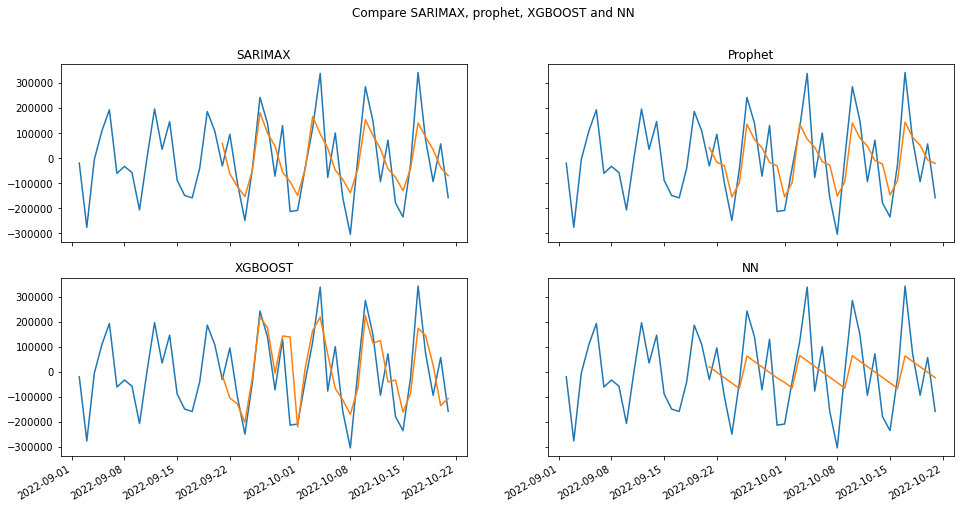

In [46]:
XGBOOST_df = pd.DataFrame({'y': xgb_pred.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset_diff.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset_diff.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset_diff.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset_diff.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('comparison',
            bbox_inches='tight', transparent=False)

#### Note: - The Prophet, XGBOOST & Neural Network models have not been finetuned with optimal hyperparameters. It may also happen that Neural Network could outperform all others when optimized.

### Next Steps: - There is one more model named as Neural Prophet - a combination of Neural Networks and Prophet. It is said to perform the best out of all Time Series models.

Link for Neural Prophet - https://neuralprophet.com/

## Follow me Here: -
Medium - https://medium.com/@pushpendrasinghcod
Linkedin - https://www.linkedin.com/in/pushpendra-singh-707a0319b/
Github - https://github.com/PkSinghDev